#### Our approach did outperform Gautamshahi's  approach and could even partly outperform Sourya's approach 

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
  
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8922609347374950549
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14657957353903662093
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]
Default GPU Device: /device:GPU:0


In [3]:
import platform
import tensorflow as tf

if tf.test.is_built_with_cuda() == False:
    print('YOU WORK WITHOUT GPU')

print(platform.machine(), '\n')
print(platform.version(), '\n')
print(platform.platform(), '\n')
print(platform.uname(), '\n')
print(platform.system(), '\n')
print(platform.processor())

x86_64 

#1 SMP Sat Jun 5 09:50:34 PDT 2021 

Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic 

uname_result(system='Linux', node='19e345c496d2', release='5.4.104+', version='#1 SMP Sat Jun 5 09:50:34 PDT 2021', machine='x86_64', processor='x86_64') 

Linux 

x86_64


In [1]:
import tensorflow as tf

import re
import pandas as pd
import numpy as np
import json
import re
import string

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

In [2]:
df_drive = pd.read_csv('fullset.csv')

### Define Tokens and Transform sequences

In [3]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
label_id = lb_make.fit_transform(df_drive.label)

df_drive['label_id'] = label_id
df_drive.dropna(inplace=True)

In [4]:
# The maximum number of most frequent words to be used.
MAX_NB_WORDS = 29000
# Max number of words in each row
MAX_SEQUENCE_LENGTH = 150
#feature vector length
HIDDEN_DIM = 150

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(df_drive['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 29601 unique tokens.


In [5]:
# define X and Y
X = tokenizer.texts_to_sequences(df_drive['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(df_drive['label']).values
print('Shape of label tensor:', Y.shape)

onehot_labels = pd.get_dummies(df_drive['label'])
labels = onehot_labels.drop_duplicates(subset=onehot_labels.columns).reset_index(drop=True)

Shape of data tensor: (14333, 150)
Shape of label tensor: (14333, 2)


#### Define Test-Train Data

In [6]:
from sklearn.model_selection  import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)

## Define Model

In [7]:
#save model
from __future__ import absolute_import, division, print_function
import os

checkpoint_path = "model_pretrain/model"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding,SpatialDropout1D, LSTM,Conv1D,MaxPooling1D
from tensorflow.keras import layers

def CovFake_model():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, HIDDEN_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2, activation='softmax'))
    
    return model 

## Train Model

In [24]:
model = CovFake_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

epochs = 15
batch_size = 64
model.fit(X_train, Y_train,epochs=epochs, batch_size=batch_size,validation_split=0.2, callbacks=[cp_callback])

Epoch 1/15
144/144 [==============================] - 60s 404ms/step - loss: 0.2931 - acc: 0.8642 - val_loss: 0.1609 - val_acc: 0.9368

Epoch 00001: saving model to model_pretrain\model
Epoch 2/15
144/144 [==============================] - 59s 413ms/step - loss: 0.0667 - acc: 0.9769 - val_loss: 0.1625 - val_acc: 0.9372

Epoch 00002: saving model to model_pretrain\model
Epoch 3/15
144/144 [==============================] - 61s 425ms/step - loss: 0.0172 - acc: 0.9953 - val_loss: 0.1598 - val_acc: 0.9490

Epoch 00003: saving model to model_pretrain\model
Epoch 4/15
144/144 [==============================] - 61s 426ms/step - loss: 0.0127 - acc: 0.9962 - val_loss: 0.1583 - val_acc: 0.9468

Epoch 00004: saving model to model_pretrain\model
Epoch 5/15
144/144 [==============================] - 61s 427ms/step - loss: 0.0052 - acc: 0.9991 - val_loss: 0.1944 - val_acc: 0.9486

Epoch 00005: saving model to model_pretrain\model
Epoch 6/15
144/144 [==============================] - 62s 428ms/step -

## Evaluation

In [32]:
_, accr = model.evaluate(X_test,Y_test)
print('\n Test set\n Accuracy: {:0.3f}'.format(accr))

90/90 [==============================] - 3s 35ms/step - loss: 0.2967 - acc: 0.9466

 Test set
 Accuracy: 0.947


In [46]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)

y_pred_label = []
for i in y_pred:
    if i[0] > i[1]:
        y_pred_label.append(0)
    else:
        y_pred_label.append(1)

y_true_label = []
for i in Y_test:
    if i[0] > i[1]:
        y_true_label.append(0)
    else:
        y_true_label.append(1)
        
print(classification_report(y_true_label, y_pred_label))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1684
           1       0.95      0.94      0.94      1183

    accuracy                           0.95      2867
   macro avg       0.95      0.95      0.95      2867
weighted avg       0.95      0.95      0.95      2867



In [47]:
labels_dic = {
    1:'real',
    0: 'fake',
}

Y_index_labels = [list(i).index(1) for i in Y_test]
Y_test_str = [labels_dic[i] for i in Y_index_labels]

y_prob = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)
Y_preds_str = [labels_dic[i] for i in list(y_classes)]

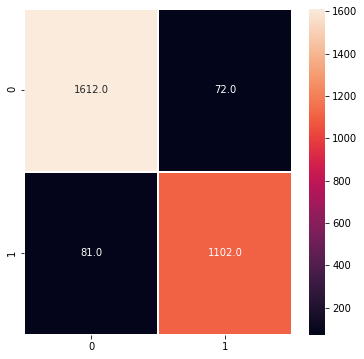

In [48]:
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = confusion_matrix(y_pred=Y_preds_str,y_true=Y_test_str)

fig,ax = plt.subplots(figsize=(6,6))
sns.heatmap(confusion_matrix,annot=True,fmt="0.1f",linewidths=1.5)
plt.show()

### Evaluation of wrong prediction

In [54]:
test_text = tokenizer.sequences_to_texts(X_test)

df_test = pd.DataFrame({'test_text':test_text, 
                        'true_label':y_true_label,
                        'pred_label': y_pred_label})

#### Fake (0) labeled as Real (1) - FalsePositives

In [143]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import stop_words as sw
from itertools import chain
import matplotlib.pyplot as plt

def cleantext(list_text):
    list_text = [item.replace('[»„‘’“”…]', ' ') for item in list_text]
    list_text = [item.replace('\w*\d\w*', 'Number') for item in list_text]
    list_text = [item.replace(r"https?://\S+|www\.\S+", ' ') for item in list_text]
    list_text = [item.replace(r'[\u0080-\uffff]w{1-3}', " ") for item in list_text]
    list_text = [item.replace(r"[^\x00-\x7F\w{1,3}]+", ' ') for item in list_text]
    list_text = [item.replace(r"[^\x00-\x7F\w{1,3}]+", ' ') for item in list_text]
    
    
    list_text = [i.split() for i in list_text]
    list_text = list(chain.from_iterable(list_text))
    
    clean_elements = ['the', 'to', 't', 'in', 'for', 'and', 'co']
    list_text = [item for item in list_text if item not in clean_elements]

    return list_text


stop_words = sw.get_stop_words('english')

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(words_fp)

In [69]:
fp_test = [rows for index,rows in df_test.iterrows() if rows.true_label == 0 and rows.pred_label == 1]
fp_test = pd.DataFrame(fp_test)

fp_texts = [i for i in list(fp_test.test_text)]
fp_texts

['for our coronawarriors coronavirusindia indiafightscorona narendramodi we are united and we will fight against such chinesevirus chinaindiafaceoff boycottmadeinchina boycottchineseproduct are u with me https t co b6m4wt1ece',
 'number of covid related deaths has fallen since federal police started an investigation on the number of deaths',
 'eating meat products increases the risk of coronavirus according to a who official quoted in the text',
 "the most up to date data in victoria for 2020 was consistent with that for 2019 despite concerns due to covid19 however the numbers remain troubling according to vic's state coroner and don't mitigate the fact that there's been an increase in calls to mental health services",
 'under new covid 19 laws walkers are now allowed to clothesline joggers who pass too close https t co ew0ozssapd',
 'the effects of coronavirus on the heart can possibly last a lifetime even in younger and healthier individuals and there seems to be evidence that sars c

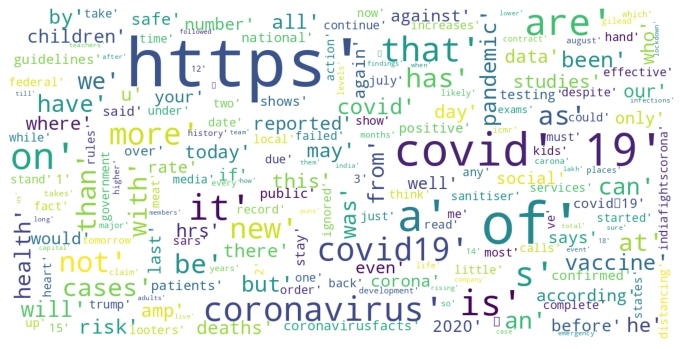

In [146]:
words_fp = cleantext(fp_texts)
show_wordcloud(words_fp)

#### Real (1) labeled as Fake (0) - FalseNegatives

In [71]:
fn_test = [rows for index,rows in df_test.iterrows() if rows.true_label == 1 and rows.pred_label == 0]
fn_test = pd.DataFrame(fn_test)

fn_texts = [i for i in list(fn_test.test_text)]
fn_texts

['twofold increase in mortality among coronavirus patients with hypertension https t co enlbntdzbl',
 'rt jesus jimz some good news the infection rate of covid 19 in dallas county is the lowest it has been since cases were first reported h…',
 'at this rate india is slated to overtake usa in testing',
 'another reason is the casual attitude of people towards covid 19 as people are seen in crowded places without any taking any precautionary measures such as wearing a facemask maintaining socialdistancing etc resulting in people getting infected with the novel coronavirus',
 "scientists ask without trial data how can we trust russia's covid vaccine https t co garcuf0pji https t co 0bdca7lf56",
 'huge job loss for doctors dentists from covid https t co 1tgno9hmct',
 'thus enhanced and timely testing is not only keeping the positivity rate low but also the fatality rate low',
 'clothing is unlikely to be a huge source of coronavirus transmission https t co 8tqzufi68l',
 'masks are now avai

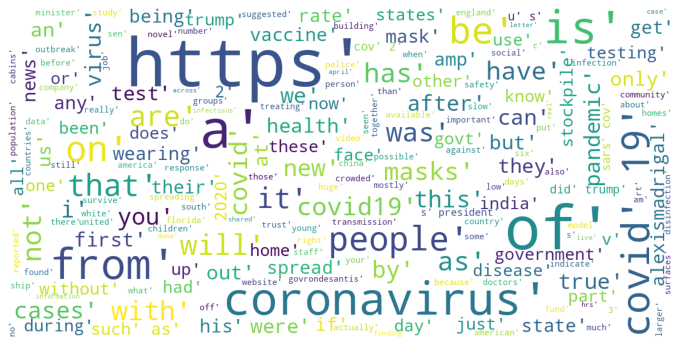

In [147]:
words_fn = cleantext(fn_texts)
show_wordcloud(words_fn)